Predicción de gastos médicos en sparklyr
===

* *30 min* | Última modificación: Junio 22, 2019

En este documento se abora como resolver este problema de regresión usando Sparklyr.

## Definición del problema

Una compañía de seguros desea pronósticar los gastos médicos de la población asegurada con el fin de recolectar un valor superior en ingresos, tal que le permita obtener utilidades. Los costos son difíciles de pronósticar ya que las condiciones más costosas son más raras y parecen aleatorias; y que ciertas condiciones son más probables para ciertos segmentos de la población (infarto en personas obesas y cáncer en fumadores).

El objetivo es usar una base de datos con 1338 registros de gastos médicos hipotéticos para pacientes de EU con el fin de estimar los costos para determinados segmentos de la población. La información registrada es la siguiente:

* Age: entero hasta 64.

* Sex: male, female.

* bmi: Body mass index.

* children: entero indicando la cantidad de hijos/dependientes cubiertos por el plan de salud.

* smoker: yes, no.

* region: northest, southeast, southwest, northwest.

* charges: costos.


## Solución

### Preparación

In [1]:
##
## Esta función se usará para ejecutar comandos en el 
## sistema operativo y capturar la salida.
##
systemp <- function(command) cat(system(command, intern = TRUE), sep = '\n')

In [2]:
library(sparklyr)
library(dplyr)
spark_installed_versions()
sc <- spark_connect(master='local', spark_home='/home/vagrant/spark/spark-2.4.3-bin-hadoop2.7')
spark_version(sc)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



spark hadoop dir                                          
1 2.4.3 2.7    /home/vagrant/spark/spark-2.4.3-bin-hadoop2.7

[1] ‘2.4.3’

### Carga de datos

Se mueve el archivo de la máquina local a sistema HDFS.

In [3]:
## copia el archivo al HDFS
systemp('hdfs dfs -copyFromLocal insurance.csv /tmp/insurance.csv') 

Warning message:
“running command 'hdfs dfs -copyFromLocal insurance.csv /tmp/insurance.csv' had status 1”

Se realizar la carga de los datos en SparkR, y se verifica la lectura del archivo.

In [4]:
spark_df <- spark_read_csv(sc,                    ## spark_connection
                           'insurance',           ## nombre de la tabla
                           '/tmp/insurance.csv')  ## ubicación del archivo
                                                  ## en el sistema hdfs
spark_df

# Source: spark<insurance> [?? x 7]
     age sex      bmi children smoker region    charges
   <int> <chr>  <dbl>    <int> <chr>  <chr>       <dbl>
 1    19 female  27.9        0 yes    southwest  16885.
 2    18 male    33.8        1 no     southeast   1726.
 3    28 male    33          3 no     southeast   4449.
 4    33 male    22.7        0 no     northwest  21984.
 5    32 male    28.9        0 no     northwest   3867.
 6    31 female  25.7        0 no     southeast   3757.
 7    46 female  33.4        1 no     southeast   8241.
 8    37 female  27.7        3 no     northwest   7282.
 9    37 male    29.8        2 no     northeast   6406.
10    60 female  25.8        0 no     northwest  28923.
# … with more rows

In [5]:
##
## Se imprime el esquema en formato de arbol
##
sdf_schema(spark_df)

$age
$age$name
[1] "age"

$age$type
[1] "IntegerType"


$sex
$sex$name
[1] "sex"

$sex$type
[1] "StringType"


$bmi
$bmi$name
[1] "bmi"

$bmi$type
[1] "DoubleType"


$children
$children$name
[1] "children"

$children$type
[1] "IntegerType"


$smoker
$smoker$name
[1] "smoker"

$smoker$type
[1] "StringType"


$region
$region$name
[1] "region"

$region$type
[1] "StringType"


$charges
$charges$name
[1] "charges"

$charges$type
[1] "DoubleType"

### Análisis exploratorio

La función `summary` de SparkR permite obtener los principales estadísticos del DataFrame. Puesto que dicha función retorna un DataFrame de Spark, es necesario usar `collect()` para visualizar la tabla de resultados.

In [6]:
summary(spark_df %>% collect())

      age            sex                 bmi           children    
 Min.   :18.00   Length:1338        Min.   :15.96   Min.   :0.000  
 1st Qu.:27.00   Class :character   1st Qu.:26.30   1st Qu.:0.000  
 Median :39.00   Mode  :character   Median :30.40   Median :1.000  
 Mean   :39.21                      Mean   :30.66   Mean   :1.095  
 3rd Qu.:51.00                      3rd Qu.:34.69   3rd Qu.:2.000  
 Max.   :64.00                      Max.   :53.13   Max.   :5.000  
    smoker             region             charges     
 Length:1338        Length:1338        Min.   : 1122  
 Class :character   Class :character   1st Qu.: 4740  
 Mode  :character   Mode  :character   Median : 9382  
                                       Mean   :13270  
                                       3rd Qu.:16640  
                                       Max.   :63770  

Por otra parte, es posible usar la función `summary` para obtener los estadísticos descriptivos de una columna. En este caso, primero se selecciona la columna y luego se aplica `summary`.

SparkR también implementa la función `histogram` para computar el histograma de una columna de un DataFrame. En este caso, debe usarse la librería `ggplot` para realizar la correspondiente gráfica.

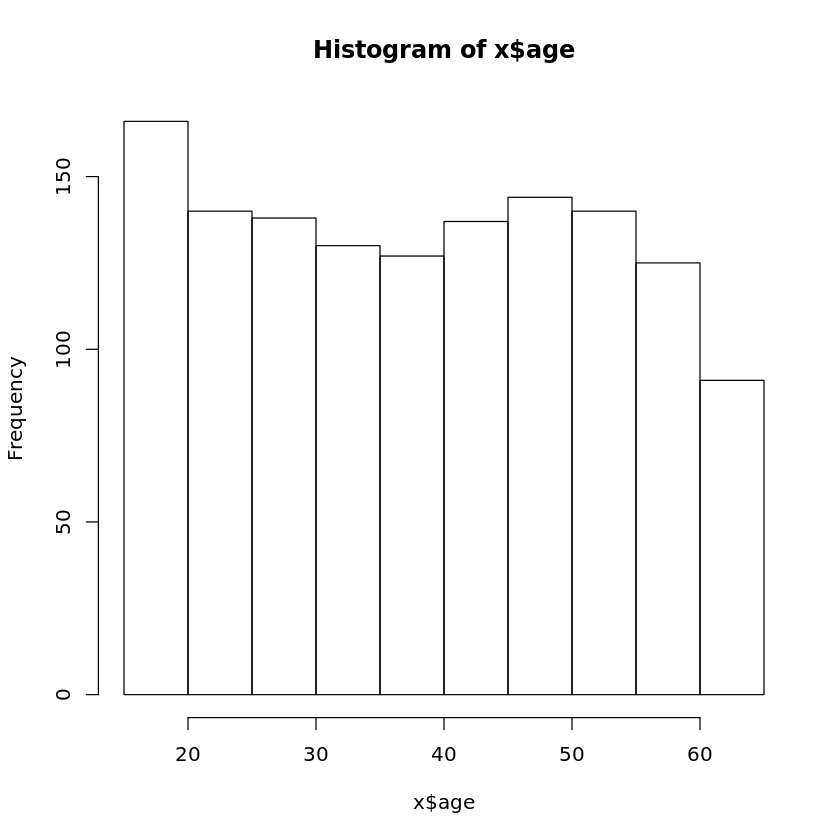

In [9]:
x <- spark_df %>% select('age') %>% collect()
hist(x$age)

Muchas funciones de uso común en R no están disponibles en SparkR, por lo que resulta necesario usar `collect()` para obtener el contenido de la variable y luego aplicar la función requerida.

In [10]:
spark_df %>%  group_by(region) %>% summarize(count = n())

# Source: spark<?> [?? x 2]
  region    count
  <chr>     <dbl>
1 northwest   325
2 southwest   325
3 southeast   364
4 northeast   324

No obstante, algunas veces es posible utilizar los operadores de agregación de SQL para realizar los cómputos equivalentes. En sl siguiente fragmento de código, se usa la función `groupBy` para calcular la cantidad de registros por región.

A continuación, se traen los datos al entorno local para calcula la correlación entre las columnas del DataFrame.

In [11]:
cor(spark_df %>% select(c("age", "bmi", "children", "charges")) %>% collect())

age       bmi       children   charges   
age      1.0000000 0.1092719 0.04246900 0.29900819
bmi      0.1092719 1.0000000 0.01275890 0.19834097
children 0.0424690 0.0127589 1.00000000 0.06799823
charges  0.2990082 0.1983410 0.06799823 1.00000000

Este procedimiento de importación de datos, también puede usarse para construir gráficos.

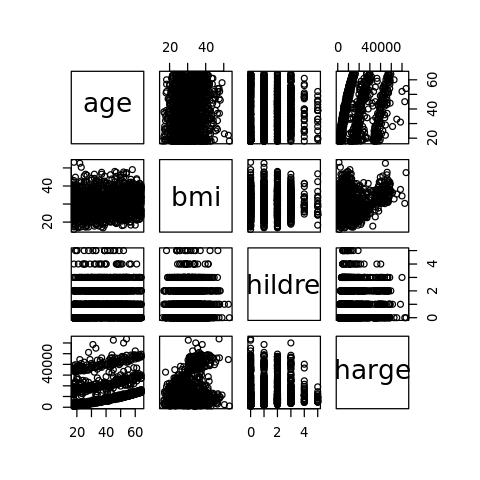

In [12]:
options(repr.plot.width = 4, repr.plot.height = 4)
pairs(spark_df %>% select(c("age", "bmi", "children", "charges")) %>% collect())

### Construcción del modelo

A continuación se usa la función `spark.gml` para la especificación de modelos lineales generalizados. Una lista de los algoritmos disponibles en SparR puede ser consultada en https://spark.apache.org/docs/latest/sparkr.html#algorithms 

In [13]:
model <- spark_df %>% ml_linear_regression(charges ~ age + children + bmi + sex + smoker + region)

In [14]:
summary(model)

Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-11304.9  -2848.1   -982.1   1393.9  29992.8 

Coefficients:
     (Intercept)              age         children              bmi 
      11909.9960         256.8564         475.5005         339.1935 
        sex_male        smoker_no region_southeast region_southwest 
       -131.3144      -23848.5345       -1035.0220        -960.0510 
region_northwest 
       -352.9639 

R-Squared: 0.7509
Root Mean Squared Error: 6042


La sintaxis sigue siendo similar a la tradicional en R. A continuación se obtiene el pronóstico del modelo para el conjunto de datos.

In [15]:
fitted <- ml_predict(model, spark_df) %>% collect
head(fitted)

age sex    bmi    children smoker region    charges   prediction
1 19  female 27.900 0        yes    southwest 16884.924 25293.713 
2 18  male   33.770 1        no     southeast  1725.552  3448.603 
3 28  male   33.000 3        no     southeast  4449.462  6706.988 
4 33  male   22.705 0        no     northwest 21984.471  3754.830 
5 32  male   28.880 0        no     northwest  3866.855  5592.493 
6 31  female 25.740 0        no     southeast  3756.622  3719.826

Finalmente, se grafica los valores reales y los pronosticados para la variable `charges`.

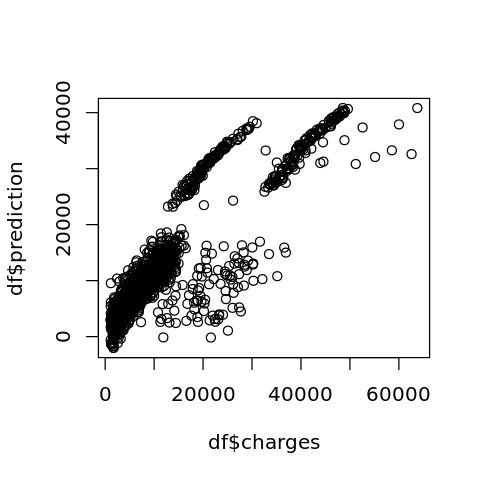

In [16]:
df <- fitted %>% select(c("charges", "prediction")) %>% collect

options(repr.plot.width = 4, repr.plot.height = 4)
plot(x=df$charges, df$prediction)